In [1]:
import os
from PIL import Image

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Flatten,Dense,Dropout
from tensorflow.keras.optimizers import Adamax
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report

In [2]:
# Generate data paths with labels
train_data_dir = './Training'
filepaths = []
labels = []

folds = os.listdir(train_data_dir)
# print(folds)

for fold in folds:
    foldpath = os.path.join(train_data_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        
        filepaths.append(fpath)
        labels.append(fold)

# Concatenate data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name= 'filepaths')
Lseries = pd.Series(labels, name='labels')

train_df = pd.concat([Fseries, Lseries], axis= 1)

In [3]:
train_df

,filepaths,labels
0,./Training\glioma\Tr-glTr_0000.jpg,glioma
1,./Training\glioma\Tr-glTr_0001.jpg,glioma
2,./Training\glioma\Tr-glTr_0002.jpg,glioma
3,./Training\glioma\Tr-glTr_0003.jpg,glioma
4,./Training\glioma\Tr-glTr_0004.jpg,glioma
...,...,...
5707,./Training\pituitary\Tr-pi_1452.jpg,pituitary
5708,./Training\pituitary\Tr-pi_1453.jpg,pituitary
5709,./Training\pituitary\Tr-pi_1454.jpg,pituitary
5710,./Training\pituitary\Tr-pi_1455.jpg,pituitary


In [4]:
test_data_dir = './Testing'
filepaths = []
labels = []

folds = os.listdir(test_data_dir)
for fold in folds:
    foldpath = os.path.join(test_data_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        
        filepaths.append(fpath)
        labels.append(fold)

# Concatenate data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name= 'filepaths')
Lseries = pd.Series(labels, name='labels')
ts_df = pd.concat([Fseries, Lseries], axis= 1)

In [5]:
ts_df

,filepaths,labels
0,./Testing\glioma\Te-glTr_0000.jpg,glioma
1,./Testing\glioma\Te-glTr_0001.jpg,glioma
2,./Testing\glioma\Te-glTr_0002.jpg,glioma
3,./Testing\glioma\Te-glTr_0003.jpg,glioma
4,./Testing\glioma\Te-glTr_0004.jpg,glioma
...,...,...
1306,./Testing\pituitary\Te-pi_0295.jpg,pituitary
1307,./Testing\pituitary\Te-pi_0296.jpg,pituitary
1308,./Testing\pituitary\Te-pi_0297.jpg,pituitary
1309,./Testing\pituitary\Te-pi_0298.jpg,pituitary


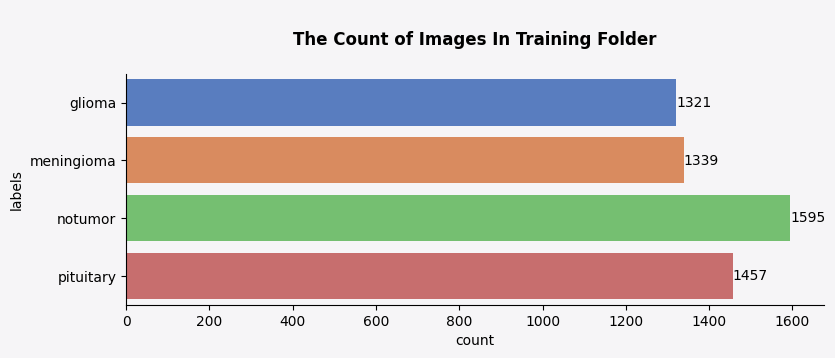

In [6]:
fig, ax = plt.subplots(figsize=(9, 3))
fig.patch.set_facecolor("#f6f5f7")
ax.set_facecolor("#f6f5f7")
for spine in ["top", "right"]:
    ax.spines[spine].set_visible(False)

x = sns.countplot(data=train_df, y=train_df["labels"], palette='muted')
for container in x.containers:
    x.bar_label(container)
plt.title("\nThe Count of Images In Training Folder\n", weight="bold")
plt.show()


Text(0.5, 1.0, '\nThe Count Of Images In Testing Folder\n')

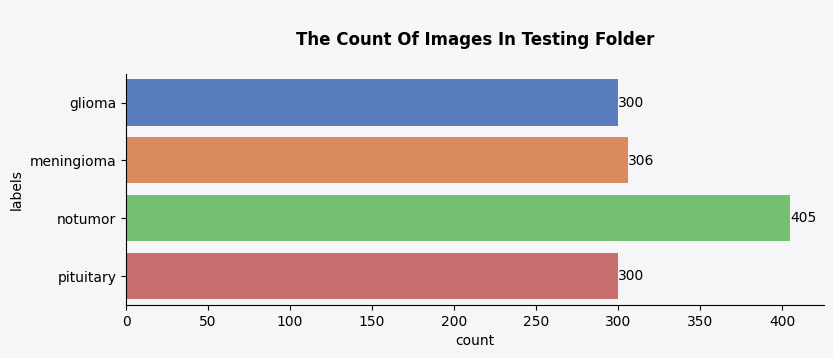

In [7]:
fig,ax=plt.subplots(figsize=(9,3))
fig.patch.set_facecolor("#f6f5f7")
ax.set_facecolor("#f6f5f7")
for i in ["right","top"]:
    ax.spines[i].set_visible(False)
    
i=sns.countplot(data=ts_df,y=ts_df["labels"],palette='muted')
for container in i.containers:
    i.bar_label(container)
    
plt.title("\nThe Count Of Images In Testing Folder\n",weight="bold")

In [8]:
ts_df.shape

(1311, 2)

## Split dataframe into train, valid, and test

In [9]:
# valid and test dataframe
valid_df, test_df = train_test_split(ts_df,  train_size= 0.5, shuffle= True, random_state= 123)

## Create image data generator

In [10]:
batch_size = 16
img_size = (224, 224)

tr_gen = ImageDataGenerator()
ts_gen = ImageDataGenerator()

train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

valid_gen = ts_gen.flow_from_dataframe( valid_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= False, batch_size= batch_size)

Found 5712 validated image filenames belonging to 4 classes.
Found 655 validated image filenames belonging to 4 classes.
Found 656 validated image filenames belonging to 4 classes.


## Show sample from train data

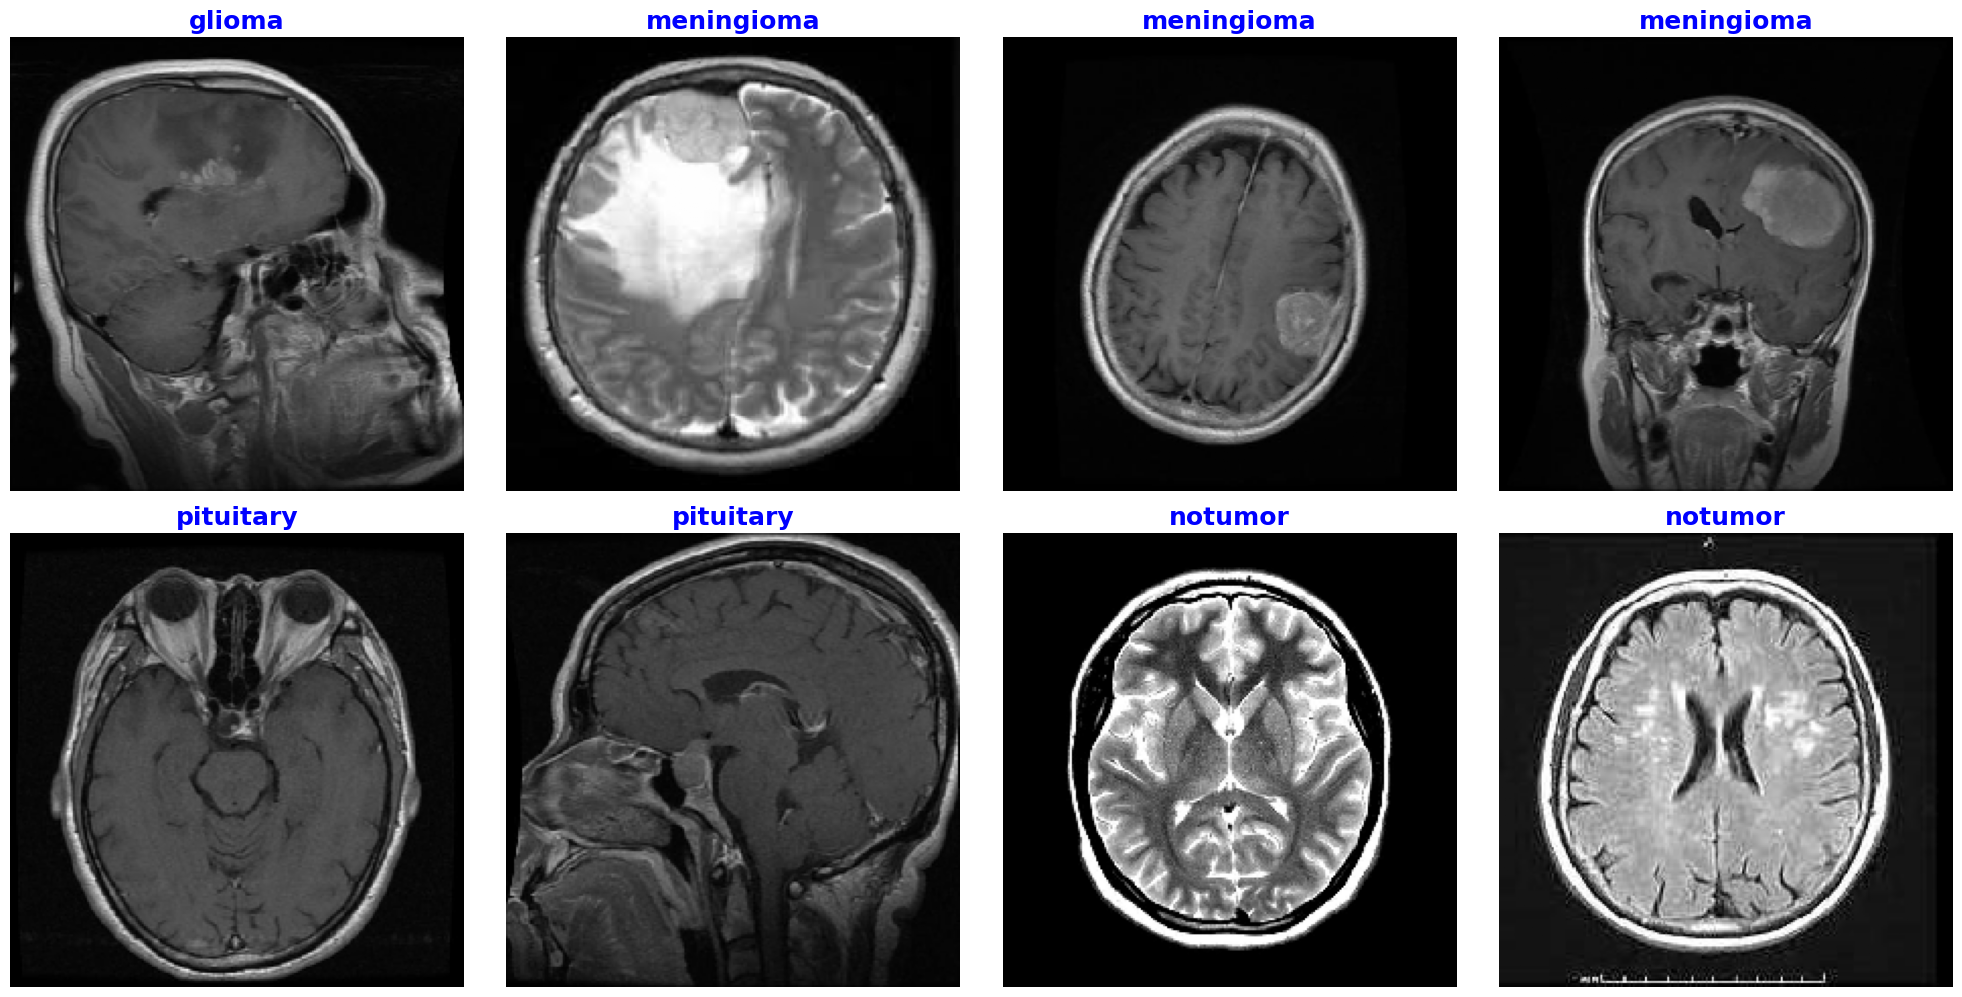

In [11]:
g_dict = train_gen.class_indices     
classes = list(g_dict.keys())       
images, labels = next(train_gen) 


plt.figure(figsize= (20, 20))

for i in range(8):
    plt.subplot(4, 4, i + 1)
    image = images[i] / 255       
    plt.imshow(image)
    index = np.argmax(labels[i])  
    class_name = classes[index]   
    plt.title(class_name, color= 'blue', fontsize= 18, weight="bold")
    plt.axis('off')
plt.tight_layout()
plt.show()

## Building Deep Learning Model

In [12]:
img_shape = (224, 224, 3)
class_count = len(list(train_gen.class_indices.keys()))
model2 = Sequential([
    Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu", input_shape= img_shape),
    Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu"),
    MaxPooling2D((2, 2)),
    
    Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"),
    MaxPooling2D((2, 2)),
    
    Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"),
    MaxPooling2D((2, 2)),
    
    Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    MaxPooling2D((2, 2)),
    
    Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    MaxPooling2D((2, 2)),
    
    Flatten(),
    
    Dense(256,activation = "relu"),
    Dense(64,activation = "relu"),
    Dense(class_count, activation = "softmax")
])

model2.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

model2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 64)      36928     
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 64)      0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 112, 112, 128)     73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 112, 112, 128)     147584    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 56, 56, 128)       0         
 g2D)                                                   

In [13]:
img_shape = (224,224, 3)

model = Sequential([
    Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu", input_shape= img_shape),
    Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu"),
    MaxPooling2D((2, 2)),
    
    Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"),
    MaxPooling2D((2, 2)),
    
    Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"),
    MaxPooling2D((2, 2)),
    
    Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    MaxPooling2D((2, 2)),
    
    Flatten(),
    
    Dense(128,activation = "relu"),
    Dense(64,activation = "relu"),
    Dense(4, activation = "softmax")
])

model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_13 (Conv2D)          (None, 224, 224, 64)      1792      
                                                                 
 conv2d_14 (Conv2D)          (None, 224, 224, 64)      36928     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 112, 112, 64)      0         
 g2D)                                                            
                                                                 
 conv2d_15 (Conv2D)          (None, 112, 112, 128)     73856     
                                                                 
 conv2d_16 (Conv2D)          (None, 112, 112, 128)     147584    
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 56, 56, 128)       0         
 g2D)                                                 

In [14]:
history = model.fit(train_gen, epochs= 10, verbose= 1, validation_data= valid_gen, shuffle= False)

Epoch 1/10
 30/357 [=>............................] - ETA: 1:51:42 - loss: 9.6887 - accuracy: 0.2792

## Display model performance

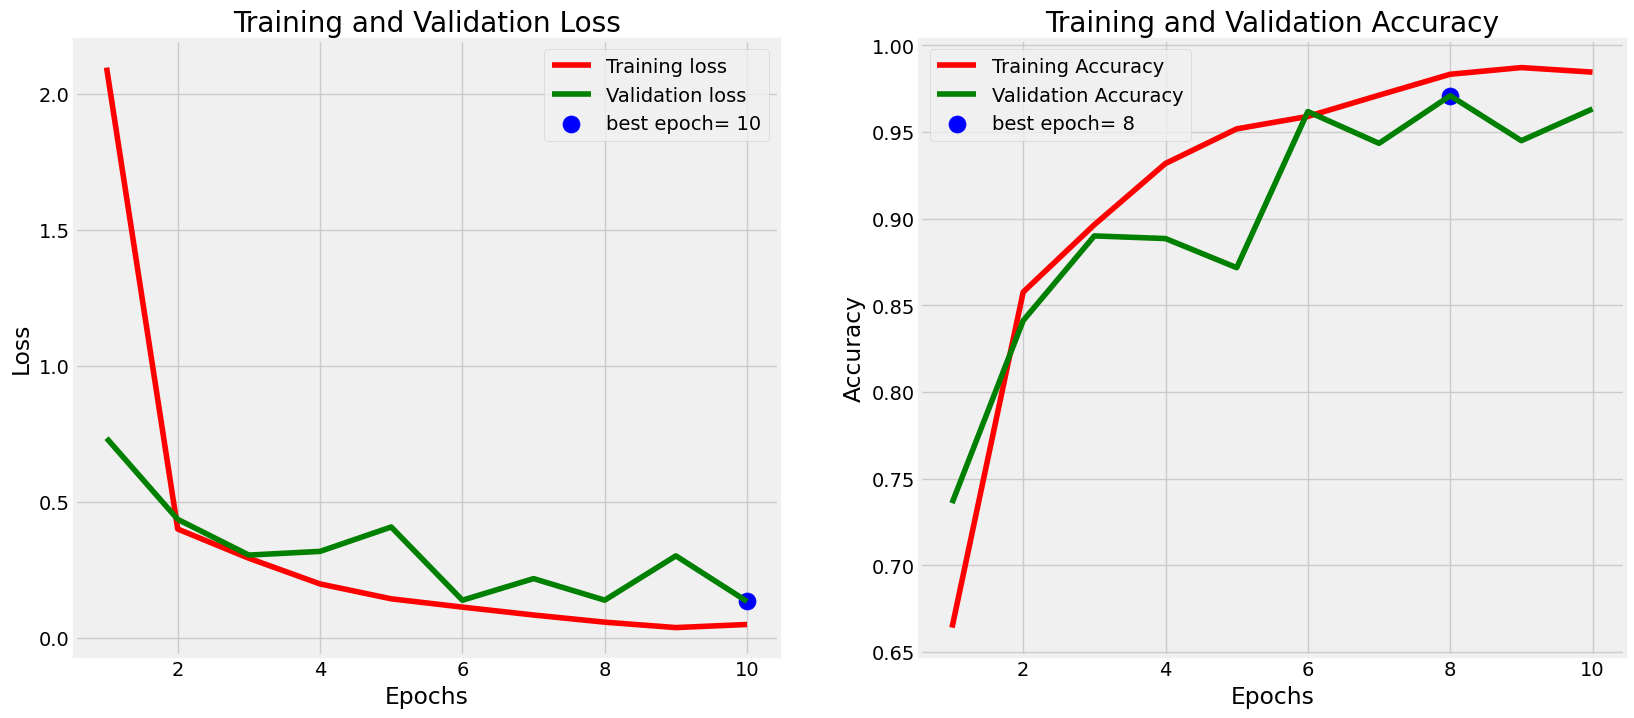

In [ ]:
# Define needed variables
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]

Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

## Evaluate model

In [ ]:
train_score = model.evaluate(train_gen, verbose= 1)
valid_score = model.evaluate(valid_gen, verbose= 1)
test_score = model.evaluate(test_gen, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

357/357 ━━━━━━━━━━━━━━━━━━━━ 16s 46ms/step - accuracy: 0.9955 - loss: 0.0169
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9609 - loss: 0.1533
41/41 ━━━━━━━━━━━━━━━━━━━━ 6s 157ms/step - accuracy: 0.9566 - loss: 0.1207
Train Loss:  0.016636308282613754
Train Accuracy:  0.9964985847473145
--------------------
Validation Loss:  0.1341988444328308
Validation Accuracy:  0.9633587598800659
--------------------
Test Loss:  0.13041119277477264
Test Accuracy:  0.957317054271698


In [ ]:
preds = model.predict(test_gen)  # Assuming test_gen is your test data generator
y_pred = np.argmax(preds, axis=1)

 6/41 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step

W0000 00:00:1710007703.550745     106 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step


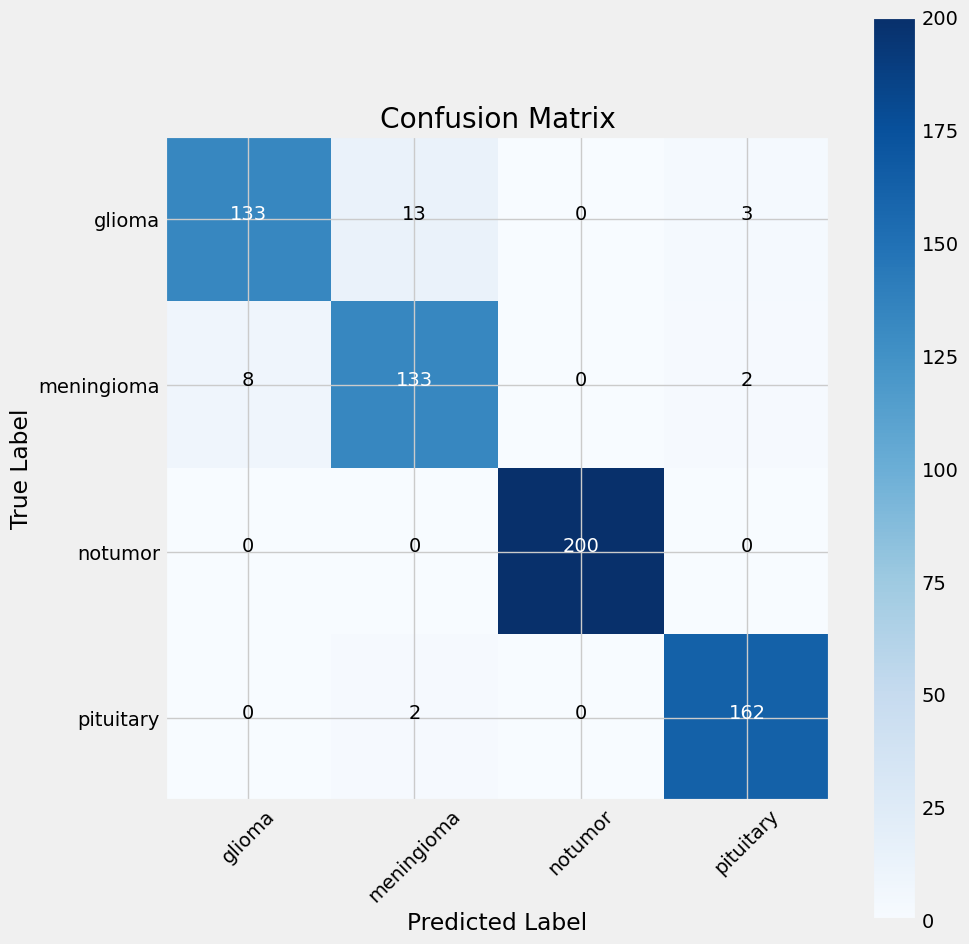

In [ ]:
import itertools  # Add this line to import itertools module

g_dict = test_gen.class_indices
classes = list(g_dict.keys())
# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)
cm

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)

thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()


In [ ]:
# Classification report
print(classification_report(test_gen.classes, y_pred, target_names= classes))

              precision    recall  f1-score   support

      glioma       0.94      0.89      0.92       149
  meningioma       0.90      0.93      0.91       143
     notumor       1.00      1.00      1.00       200
   pituitary       0.97      0.99      0.98       164

    accuracy                           0.96       656
   macro avg       0.95      0.95      0.95       656
weighted avg       0.96      0.96      0.96       656



In [ ]:
model.save('tumor_classifier.h5')
